# WorkGraph Tutorial: MD Simulation with DFT Labeling and MLIP Fine-tuning

This tutorial demonstrates building complex workflows with AiiDA WorkGraph making use of a remote system (SCARF), and using Quantum ESPRESSO for generating DFT-labeled training data and fine-tuning a machine learning interatomic potential (MLIP).

## Workflow Steps

1. **MD Simulation** → Generate diverse NaCl configurations (6 snapshots)
2. **Descriptors** → Calculate MLIP features for filtering (dynamic tasks)
3. **Data Split** → FPS filtering into train/validation/test sets
4. **DFT Labeling** → Quantum ESPRESSO energies, forces, stresses (nested dynamic tasks)
5. **Training Files** → Format ExtXYZ files with DFT labels
6. **Fine-tuning** → Train MACE model on DFT data

## WorkGraph Features

- **Dynamic task generation**: Create tasks at runtime based on trajectory length
- **Nested namespaces**: Organize complex hierarchical outputs
- **Automatic dependencies**: Tasks execute when inputs become available
- **Parallel execution**: Independent calculations run simultaneously
- **Provenance tracking**: Full AiiDA database tracking of all calculations and data for reproducibility
- **Mixed local and remote execution**: MD runs locally while DFT calculations execute on HPC clusters

### Setup

For this tutorial we will assume you have: 
<ul>
        <li>An AiiDA profile setup</li>
        <li>An external computer setup in AiiDA with a quantum espresso code</li>
                <ul>
                        <li>A tutorial can be found in <a href="../aiida_setup/setup-external-computer.ipynb"><code>../aiida_setup/setup-external-computer.ipynb</code></a></li>
                </ul>
        <li>The <code>aiida-quantumespresso</code>, <code>aiida-pseudo</code> and <code>fpsample</code> extra dependancies installed</li>
        <li>Pseudopotentails SSSP installed</li>
                <ul>
                        <li>They can be installed with: <code>aiida-pseudo install sssp</code></li>
                </ul>

</ul>

The initial setup is very similar to the other tutorials, such as [singlepoint.ipynb](https://stfc.github.io/aiida-mlip/user_guide/notebooks/singlepoint.html), which goes into more detail about what each step is doing


### Load AiiDA Profile

In [1]:
from aiida import load_profile
load_profile()

Profile<uuid='60b17659a9844c4bbd3bef8de0a8f417' name='presto'>

### Load ML Potential Model

We download a pre-trained MACE model from the janus-core repository. 

The `ModelData.from_uri()` function automatically caches the model locally to avoid repeated downloads.

In [2]:
from aiida_mlip.data.model import ModelData
uri = "https://github.com/stfc/janus-core/raw/main/tests/models/mace_mp_small.model"
model = ModelData.from_uri(uri, architecture="mace_mp", cache_dir="mlips")

### Define Initial Structure

We create a rocksalt NaCl structure with a lattice parameter of 5.63 Å. This serves as the starting point for our MD simulation.

In [3]:
from aiida.orm import StructureData
from ase.build import bulk
from ase.io import read, iread

# structure = StructureData(ase=read("Structures/qmof-ffeef76.cif"))
init_structure = StructureData(ase=bulk("NaCl", "rocksalt", 5.63))

### Load Computational Codes

We need two codes:
- **janus@localhost**: For MLIP calculations (MD, descriptors, training) - runs locally
- **qe@scarf**: For DFT calculations with Quantum ESPRESSO - runs on HPC cluster

See examples>tutorials>aiida_setup for setting up janus code and external computers.

In [4]:
from aiida.orm import load_code
janus_code = load_code("janus@localhost")
qe_code = load_code("qe@scarf")

### Define Calculation Types

We define three calculation types from the `aiida-mlip` plugin:
- `mdCalc`: Molecular dynamics simulation
- `descriptorsCalc`: Compute structural descriptors  
- `trainCalc`: Fine-tune the MLIP model

In [5]:
from aiida.plugins import CalculationFactory

mdCalc = CalculationFactory("mlip.md")
descriptorsCalc = CalculationFactory("mlip.descriptors")
trainCalc = CalculationFactory("mlip.train")

## Dynamic Task Creation with Descriptors

### WorkGraph Concepts

WorkGraph provides three task decorators:
- `task(CalculationClass)`: Wrap AiiDA calculations
- `@task.calcfunction`: Wrap AiiDA calcfunctions  
- `@task.graph`: Create a sub-workflow (task graph)

The `@task.graph` decorator below with `dynamic(SinglefileData)` outputs creates a pattern: the number of output tasks is determined at runtime based on trajectory length. WorkGraph automatically:
1. Tracks dependencies between all generated tasks
2. Executes them in parallel when resources allow
3. Collects all results into the `final_structs` output

### Scientific Purpose

After MD generates trajectory snapshots, we calculate descriptors for each structure. These descriptors:
- Characterize the local atomic environment around each atom
- Enable intelligent filtering of diverse configurations
- Are calculated per-element (separate Na and Cl descriptors)
- Feed into FPS (Farthest Point Sampling) for optimal train/test split

The loop creates one descriptor calculation per MD snapshot, all running in parallel:

In [6]:
from aiida_workgraph import WorkGraph, task, dynamic, namespace
from aiida.orm import SinglefileData

descriptorsTask = task(descriptorsCalc)

@task.graph(outputs=namespace(final_structs=dynamic(SinglefileData)))
def descriptors_task(
    code,
    model,
    device,
    arch,
    file,
):
    results = {}
    
    with file.as_path() as path:
        for i, structs in enumerate(iread(path)):
            structure = StructureData(ase=structs)

            desc_calc = descriptorsTask(
                code=code,
                model=model,
                device=device,
                arch=arch,
                struct=structure,
                calc_per_element=True,
                metadata={"options": {"resources": {"num_machines": 1}}}
            )

            results[f"struct{i}"] = desc_calc.xyz_output

    return {"final_structs": results}

defining outputnode


## Nested Dynamic Tasks with Quantum ESPRESSO

### WorkGraph features:

**Namespaces**: `namespace(trajectory=TrajectoryData, parameters=Dict)` defines a structured output with multiple typed fields. Each DFT calculation returns both trajectory (forces/stress) and parameters (energy).

**Nested Dynamic Outputs**: The output specification creates a hierarchical structure:
- Three fixed categories: `test_file`, `train_file`, `valid_file`
- Each category contains a dynamic number of structures (determined at runtime)
- Each structure returns a namespace with both trajectory and parameters

This task processes three input files and creates dozens of DFT calculations. WorkGraph automatically parallelizes all independent calculations and organizes outputs hierarchically.

### Scientific Purpose  

Run high-accuracy DFT calculations with Quantum ESPRESSO to obtain reference data:
- **Total energy**: Ground state energy for each structure
- **Forces**: Atomic forces for training force predictions
- **Stress tensor**: Needed for NPT dynamics and equation of state

**DFT Settings**:
- SCF calculation (self-consistent field)
- SSSP pseudopotentials with recommended cutoffs (`ecutwfc`, `ecutrho`)
- Γ-point only (1×1×1 k-point mesh) - sufficient for supercell size
- `tprnfor=True`: Calculate forces, `tstress=True`: Calculate stress tensor

In [7]:
from aiida.orm import (
    TrajectoryData,
    StructureData, 
    load_group, 
    KpointsData, 
    InstalledCode, 
    List, 
    Dict,
)
from pathlib import Path
import yaml
from aiida_quantumespresso.calculations.pw import PwCalculation

PwTask = task(PwCalculation)
qe_output = namespace(trajectory=TrajectoryData, parameters=Dict)

@task.graph(
    outputs=namespace(
        test_file=dynamic(qe_output),
        train_file=dynamic(qe_output),
        valid_file=dynamic(qe_output),
    )
)
def qe(
    code: InstalledCode,
    kpoints_mesh: List,
    task_metadata: Dict,
    test_file: SinglefileData,
    train_file: SinglefileData,
    valid_file: SinglefileData
    ):

    kpoints = KpointsData()
    kpoints.set_kpoints_mesh(kpoints_mesh)

    pseudo_family = load_group('SSSP/1.3/PBE/efficiency')
    
    files = {"test_file": test_file, "train_file": train_file, "valid_file": valid_file}
    results = {"test_file": {}, "train_file": {}, "valid_file": {}}
    
    for file_name, file in files.items():
        with file.as_path() as path:
            for i, structs in enumerate(iread(path, format="extxyz")):
                
                structure = StructureData(ase=structs)
                pseudos = pseudo_family.get_pseudos(structure=structure)

                ecutwfc, ecutrho = pseudo_family.get_recommended_cutoffs(
                    structure=structure,
                    unit='Ry',
                )

                pw_params = {
                    "CONTROL": {
                        "calculation": "scf",
                        'tprnfor': True,
                        'tstress': True,
                    },
                    "SYSTEM": {
                        "ecutwfc": ecutwfc,
                        "ecutrho": ecutrho,
                    },
                }
                
                qe_task = PwTask(
                    code=code,
                    parameters=pw_params,
                    kpoints=kpoints,
                    pseudos=pseudos,
                    metadata=task_metadata.value,
                    structure=structure,
                )
                
                structfile = f"{file_name}.struct{i}"

               
                results[file_name][f"struct_{i}"] = {
                    "trajectory": qe_task.output_trajectory,
                    "parameters": qe_task.output_parameters,
                }
    return results

## CalcFunction Tasks for Data Processing

### WorkGraph Concepts

The `@task.calcfunction` decorator wraps Python functions with full provenance tracking:
- All inputs and outputs are stored in AiiDA's database
- Can receive dynamic outputs from upstream tasks (like nested QE results)
- Process complex nested data structures
- Return AiiDA data types that flow to downstream tasks

### Scientific Purpose

Extract DFT results from Quantum ESPRESSO and format for MLIP training:

1. **Extract data** from QE output:
   - Energy from `output_parameters`
   - Forces from `output_trajectory`
   - Stress tensor from `output_trajectory`

2. **Unit conversion**:
   - Stress: GPa → eV/Å³ (multiply by `units.GPa`)
   - Energy: Already in eV
   - Forces: Already in eV/Å

3. **Create ExtXYZ files**: Training data format with atomic positions, lattice vectors, and DFT labels (energy, forces, stress) in the info dict and arrays

4. **Update config**: Adds file paths to `JanusConfigfile.yml` for MACE training

In [8]:
from aiida_mlip.data.config import JanusConfigfile
from aiida.orm import Dict
from ase.io import write
from ase import units

@task.calcfunction(outputs = ["JanusConfigfile"])
def create_train_file(**inputs):

    training_files = {}
    
    for file_name, structs in inputs.items():
        path = Path(f"mlip_{file_name}.extxyz")

        for struct_out_params in structs.values():
            
            trajectory = struct_out_params["trajectory"]

            fileStructure = trajectory.get_structure(index=0)
            fileAtoms = fileStructure.get_ase()

            stress = trajectory.arrays["stress"][0]
            converted_stress = stress * units.GPa
            fileAtoms.info["qe_stress"] = converted_stress

            fileAtoms.info["units"] = {
                "energy": "eV",
                "forces": "ev/Ang",
                "stress": "ev/Ang^3"
            }
            fileAtoms.set_array("qe_forces", trajectory.arrays["forces"][0])

            parameters = struct_out_params["parameters"]
            fileParams = parameters.get_dict()
            fileAtoms.info["qe_energy"] = fileParams["energy"]
            write(path, fileAtoms, append=True)

        training_files[file_name] = str(path.resolve())

    with open("JanusConfigfile.yml", "a") as f:
        yaml.safe_dump(training_files, f, sort_keys=False)

    return{'JanusConfigfile': JanusConfigfile(Path("JanusConfigfile.yml").resolve())}

## Data Filtering and Splitting

Split the MD trajectory into train/validation/test sets using **FPS (Farthest Point Sampling)** on the descriptor space:
- Selects structures that are maximally diverse in configuration space
- Ensures training set covers a wide range of atomic environments
- Prevents redundant similar structures

Note: The warnings about k is too large appear when you have fewer structures than the target split size - the algorithm automatically adjusts.

In [9]:
from aiida.orm import Int
from sample_split import process_and_split_data

@task.calcfunction(outputs = ["test_file", "train_file", "valid_file"])
def create_qe_files(**inputs):

    n_samples = Int(len(inputs['trajectory_data']))
    print(n_samples)

    files = process_and_split_data( 
        **inputs,
        n_samples=n_samples,
    )

    return {
        "train_file": SinglefileData(files["train_file"]),
        "test_file": SinglefileData(files["test_file"]),
        "valid_file": SinglefileData(files["valid_file"])
    }

## Configure Input Parameters

Set up parameters for each workflow stage:

**MD Simulation**:
- **NVT Ensemble**: Constant Number of particles, Volume, and Temperature
- Uses thermostat to control temperature, samples structural variations
- `steps=10`: Very short MD for tutorial (use 1000+ for real applications)
- `traj-every=2`: Save every 2nd snapshot

**DFT Calculations**:
- Resources: 1 node, 32 MPI processes
- K-points: Γ-point only (1×1×1)
- Time limit: 1 hour per calculation
- HPC-specific: Module loading for Quantum ESPRESSO on SCARF

**Data Splitting**:
- `scale=1.0e5`: Scaling factor for FPS algorithm

In [10]:
from aiida.orm import Str, Float, Bool, Dict
inputs = {
    "code": janus_code,
    "model": model,
    "arch": Str(model.architecture),
    "device": Str("cpu"),
    "metadata": {"options": {"resources": {"num_machines": 1}}},
    "ensemble": Str("NVT"),
    "struct": init_structure,
    "md_kwargs": Dict(
        {
            "steps": 10,
            "traj-every": 2
        }
    )
}
calc_inputs = {
    "code": janus_code,
    "model": model,
    "arch": Str(model.architecture),
    "device": Str("cpu"),
    "metadata": {"options": {"resources": {"num_machines": 1}}},
}
split_task_inputs = {
    "config_types": Str(""),
    "prefix": Str(""),
    "scale": Float(1.0e5),
    "append_mode": Bool(False),
}
qe_inputs = {
    "task_metadata": Dict({
            "options": {
                "resources": {
                    "num_machines": 1,
                    "num_mpiprocs_per_machine": 32,
                },
                "max_wallclock_seconds": 3600,
                "queue_name": "scarf",
                "qos": "scarf",
                "environment_variables": {},
                "withmpi": True,
                "prepend_text": """
                    module purge
                    module use /work4/scd/scarf562/eb-common/modules/all
                    module load amd-modules
                    module load QuantumESPRESSO/7.2-foss-2023a
                """,
                "append_text": "",
            },
    }),
    "kpoints_mesh": List([1, 1, 1]),
    "code": qe_code,
}

## Assembling the WorkGraph

Combine all tasks into a single workflow using the `@task.graph()` decorator.

### WorkGraph Dependency Management

WorkGraph analyzes the data flow and automatically determines execution order:
- `md_calc` → `descriptors_calc` (via `traj_file`)
- `descriptors_calc` → `split_task` (via `final_structs`)
- `split_task` → `qe_task` (via train/test/valid files)
- `qe_task` → `create_train_file` (via DFT results)
- `create_train_file` → `train_task` (via config file)

### Parallel Execution

Tasks run in parallel when independent:
- All descriptor calculations execute simultaneously (one per MD snapshot)
- All QE calculations within each dataset run in parallel
- Local tasks (MD, descriptors, training) don't block remote execution (DFT on HPC)

You don't manage job submission or dependencies manually - WorkGraph handles it all.

In [11]:
mdTask = task(mdCalc)
trainTask = task(trainCalc)

@task.graph()
def md_training_workflow(
    janus_code,
    qe_code,
    model,
    md_kwargs,
    ensemble,
    init_structure,
    split_inputs,
    qe_metadata,
    qe_kpoints,
):
    md_calc = mdTask(
        code=janus_code,
        model=model,
        arch=Str(model.architecture),
        device=Str("cpu"),
        metadata={"options": {"resources": {"num_machines": 1}}},
        ensemble=ensemble,
        struct=init_structure,
        md_kwargs=md_kwargs
    )

    descriptors_calc = descriptors_task(
        code=janus_code,
        model=model,
        device=Str("cpu"),
        arch=Str(model.architecture),
        file=md_calc.traj_file
    )
   
    split_task = create_qe_files(
        **split_inputs,
        trajectory_data=descriptors_calc.final_structs,
    )
    
    qe_task = qe(
        code=qe_code,
        kpoints_mesh=qe_kpoints,
        task_metadata=qe_metadata,
        test_file=split_task.test_file,
        train_file=split_task.train_file,
        valid_file=split_task.valid_file,
    )

    training_files = create_train_file(
        test_file=qe_task.test_file,
        train_file=qe_task.train_file,
        valid_file=qe_task.valid_file,
    )

    train_task = trainTask(
        mlip_config=training_files.JanusConfigfile,
        code=janus_code,
        foundation_model=model,
        metadata={"options": {"resources": {"num_machines": 1}}},
        fine_tune=True,
    )

### Build the WorkGraph

In [12]:
wg = md_training_workflow.build(
    janus_code=janus_code,
    qe_code=qe_code,
    model=model,
    md_kwargs=inputs["md_kwargs"],
    ensemble=inputs["ensemble"],
    init_structure=init_structure,
    split_inputs=split_task_inputs,
    qe_metadata=qe_inputs["task_metadata"],
    qe_kpoints=qe_inputs["kpoints_mesh"],
)

### Visualize

In [13]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'md_trai…

### Run the Workflow

In [14]:
wg.run()

01/27/2026 10:03:50 AM <773111> aiida.broker.rabbitmq: [WARNING] RabbitMQ v3.12.1 is not supported and will cause unexpected problems!
01/27/2026 10:03:50 AM <773111> aiida.broker.rabbitmq: [WARNING] It can cause long-running workflows to crash and jobs to be submitted multiple times.
01/27/2026 10:03:50 AM <773111> aiida.broker.rabbitmq: [WARNING] See https://github.com/aiidateam/aiida-core/wiki/RabbitMQ-version-to-use for details.
01/27/2026 10:03:51 AM <773111> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [9286|WorkGraphEngine|continue_workgraph]: tasks ready to run: MD
01/27/2026 10:03:51 AM <773111> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [9286|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 9289


/home/qoj42292/.aiida/scratch/presto/d3/1a/7caa-47fa-46e3-8f31-9a824fb135eb md-summary.yml


01/27/2026 10:04:03 AM <773111> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [9286|WorkGraphEngine|update_task_state]: Task: MD, type: CALCJOB, finished.
01/27/2026 10:04:04 AM <773111> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [9286|WorkGraphEngine|continue_workgraph]: tasks ready to run: descriptors_task
01/27/2026 10:04:04 AM <773111> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [9286|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 9306
01/27/2026 10:04:05 AM <773111> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [9306|WorkGraphEngine|continue_workgraph]: tasks ready to run: Descriptors,Descriptors1,Descriptors2,Descriptors3,Descriptors4,Descriptors5
01/27/2026 10:04:06 AM <773111> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [9306|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 9311, 9316, 9321, 9326, 9331, 9336
01/27/2026 10:

uuid: 6b6ddc6a-9020-4bbd-ba57-bc74ec21ceaa (unstored) value: 6
create files: train_file=PosixPath('train.xyz'), valid_file=PosixPath('valid.xyz') and test_file=PosixPath('test.xyz')
Processing: ('all', 'aiida'), 6 frames
  ('all', 'aiida'): total=6, train_target=4,                     vt_target=2


/home/qoj42292/aiida-mlip/.venv/lib/python3.12/site-packages/fpsample/wrapper.py:98: UserWarning: k is too large, set to 6
  warnings.warn(f"k is too large, set to {n_pts}")
/home/qoj42292/aiida-mlip/.venv/lib/python3.12/site-packages/fpsample/wrapper.py:98: UserWarning: k is too large, set to 2
  warnings.warn(f"k is too large, set to {n_pts}")
01/27/2026 10:04:38 AM <773111> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [9286|WorkGraphEngine|update_task_state]: Task: create_qe_files, type: CALCFUNCTION, finished.
01/27/2026 10:04:38 AM <773111> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [9286|WorkGraphEngine|continue_workgraph]: tasks ready to run: qe
01/27/2026 10:04:39 AM <773111> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [9286|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 9384
01/27/2026 10:04:40 AM <773111> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [9384|WorkGra

{}

## Results

**Scientific**: Fine-tuned MACE model for NaCl with DFT-labeled training data (energies, forces, stresses)

**WorkGraph**: Demonstrated dynamic task creation, nested namespaces, automatic dependencies, and parallel execution with full provenance tracking

## Training Plot

If we want to get the training plot, we have to pull it from the remote folder. First lets see whats in there:

In [15]:
# List all files in the training task's remote folder
folder = wg.tasks.Train.outputs.remote_folder.value
print("Available files and directories in remote folder:")
print("-" * 50)
for item in folder.listdir():
    print(item)

Available files and directories in remote folder:
--------------------------------------------------
test.model
aiida-stdout.txt
_aiidasubmit.sh
checkpoints
test_compiled.model
.aiida
mlip_train.yml
logs
mlff.model
_scheduler-stdout.txt
results
_scheduler-stderr.txt
janus_results


Explore the results to find the PNG that the MACE trainer generates and display it.

Files in results directory:
--------------------------------------------------
test_run-123_train_Default_stage_one.png
test_run-123_train.txt


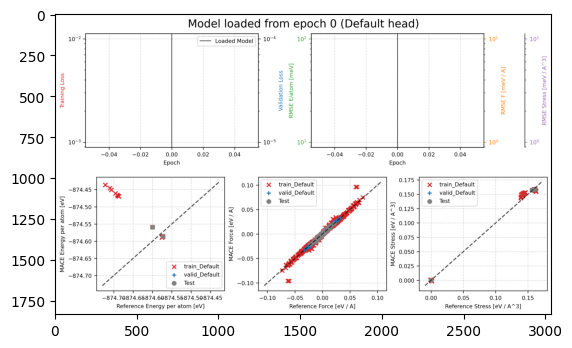

In [19]:
# List all files in the results subdirectory
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print("Files in results directory:")
print("-" * 50)
for item in folder.listdir('results'):
    print(item)
picturePath = Path.cwd() / "training_plot.png"
folder.getfile(relpath='results/test_run-123_train_Default_stage_one.png',destpath=picturePath)

img = mpimg.imread(picturePath)
plt.imshow(img)